# Linear Regression Code Along

![](https://media.giphy.com/media/srPaLAtDTsKuk/giphy.gif)

In today's code along, we will walk through the linear regression workflow using a carseat dataset.  We will cover

- train/test split
- EDA and data cleaning
- fitting regression objects in both sklearn and statsmodels
- Validation metrics: R^2, adjusted R^2, mse/rmse
- Checking our assumptions of linear regression

We will create a base model whose metrics we can use as a point of comparison.  More indepth feature engineering, which we will cover tomorrow, will aim to improve those metrics.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

%load_ext autoreload
%autoreload 2

## Scenario: car seat sales

Description: simulated data set on sales of car seats (baby seats)<br>
Format: 400 observations on the following 11 variables
- Sales: unit sales at each location
- CompPrice: price charged by nearest competitor at each location
- Income: community income level
- Advertising: local advertising budget for company at each location
- Population: population size in region (in thousands)
- Price: price charged for car seat at each site
- Age: average age of the local population
- Education: education level at each location


In [4]:
original_df = pd.read_csv('Carseats.csv')
carseats = original_df.copy()
# We will only look at numeric datatypes today.  
# Note, do not exclude object types in practice! 
# This is purely for demonstration, and we will work with objects tomorrow. 
carseats = carseats.select_dtypes(exclude = 'object')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
0,9.50,138,73,11,276,120,42,17
1,11.22,111,48,16,260,83,65,10
2,10.06,113,35,10,269,80,59,12
3,7.40,117,100,4,466,97,55,14
4,4.15,141,64,3,340,128,38,13


## Train/Test Split

In [5]:
## First thing's first: Train/Test Split
# We want to split off our test data, then not touch it 
# until our model is performing well on the training set.
from sklearn.model_selection import train_test_split

In [6]:
# Our continuous target variable is the sales attribute.
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

# Our test size can vary, but a common size is .3.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [7]:
# set aside X_test/y_test for validation purposes

In [8]:
# Let's merge X_train into y_train so that 
# if we drop rows, the data will not get messed up
car_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [9]:
car_train.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Sales
157,121,58,8,249,90,48,13,10.21
109,115,65,0,217,90,60,17,8.98
17,147,74,13,251,131,52,10,12.29
347,96,39,0,161,112,27,14,6.88
24,145,119,16,294,113,42,12,10.14


## EDA

In [10]:
## EDA
# What is the shape of our data?
car_train.shape

(280, 8)

(array([ 5.,  9., 31., 57., 63., 48., 35., 25.,  5.,  2.]),
 array([ 0.   ,  1.563,  3.126,  4.689,  6.252,  7.815,  9.378, 10.941,
        12.504, 14.067, 15.63 ]),
 <a list of 10 Patch objects>)

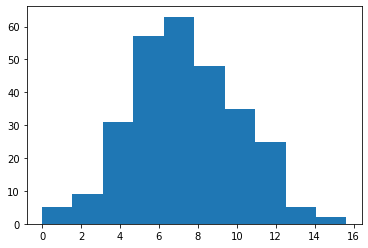

In [11]:
# Let's look at the distribution of our target variable
import matplotlib.pyplot as plt
plt.hist(car_train.Sales)

In [12]:
# That looks roughly normally distributed.  
# If it were right-skewed, a log transform might improve our model.

In [13]:
# check for nan's and inspect datatypes 
car_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 157 to 102
Data columns (total 8 columns):
CompPrice      280 non-null int64
Income         280 non-null int64
Advertising    280 non-null int64
Population     280 non-null int64
Price          280 non-null int64
Age            280 non-null int64
Education      280 non-null int64
Sales          280 non-null float64
dtypes: float64(1), int64(7)
memory usage: 29.7 KB


In [14]:
# Drop Duplicates

In [15]:
car_train.drop_duplicates().shape == car_train.shape

True

In [16]:
car_train.shape

(280, 8)

(array([1, 2, 3, 4, 5, 6, 7, 8]), <a list of 8 Text xticklabel objects>)

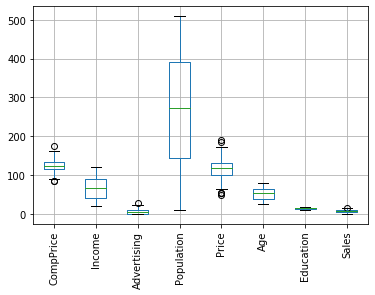

In [17]:
# Now let's look for outliers
car_train.boxplot()
plt.xticks(rotation=90)

In [18]:
# The outliers are easier to see if we standardize the data
# Standard Scaling is also necessary for regularization and 
# models which use distance metrics
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features = pd.DataFrame(ss.fit_transform(car_train.drop('Sales', axis=1)))
features.columns = X_train.columns
features.index = X_train.index
features.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education
157,-0.237664,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613
109,-0.619016,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686
17,1.414862,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337
347,-1.826631,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962
24,1.287744,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188


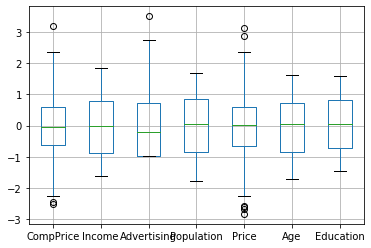

In [19]:
features.boxplot()

In [20]:
with open('scaler.p', 'wb') as write_file:
    pickle.dump(ss, write_file)

In [21]:
car_standard = pd.merge(features, car_train['Sales'], left_index=True, right_index=True)
car_standard.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Sales
157,-0.237664,-0.321877,0.259459,-0.117029,-1.111241,-0.311341,-0.321613,10.21
109,-0.619016,-0.075054,-0.979749,-0.338483,-1.111241,0.418670,1.204686,8.98
17,1.414862,0.242290,1.033964,-0.103189,0.612451,-0.068004,-1.466337,12.29
347,-1.826631,-0.991826,-0.979749,-0.726027,-0.186333,-1.588861,0.059962,6.88
24,1.287744,1.829009,1.498667,0.194390,-0.144292,-0.676347,-0.703188,10.14


In [22]:
# Now we can get rid of outliers using z scores
from scipy import stats
car_standard = car_standard[(np.abs(stats.zscore(car_standard)) < 2.5).all(axis=1)]


In [23]:
car_standard.shape

(268, 8)

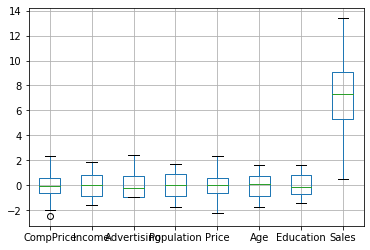

In [24]:
car_standard.boxplot()

In [25]:
# Messy/Base Model
from sklearn.linear_model import LinearRegression


In [26]:
# split back into target and features
y_train = car_standard['Sales']
X_train = car_standard.drop('Sales', axis=1)

In [27]:
# fit a messy model (do you fit your model before or after checking the assumptions?)
# obviously you have to fit your model before checking the residuals

# instantiate a LinearRegression() instance
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
lm = LinearRegression()
lm.fit(X_train, y_train)

# look at the coefficients
lm.coef_

pd.DataFrame(lm.coef_).set_index(X_train.columns)


,0
CompPrice,1.321270
Income,0.162364
Advertising,0.833854
Population,0.027909
Price,-1.978483
Age,-0.729797
Education,-0.123812


In [28]:
y_hat = lm.predict(X_train)
lm.score(X_train, y_train)

0.4902451232517083

Interpret this score: What is R^2? The amount of variance explained

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
y_train_hat = lm.predict(X_train)
r2_score(y_train, y_train_hat)

0.4902451232517083

In [31]:
mse = mean_squared_error(y_train, y_train_hat)
mse

3.410644703506049

In [32]:
import numpy as np
rmse = np.sqrt(mse)
rmse

1.8467930862730804

## Statsmodels

In [33]:
# statsmodel
import statsmodels.formula.api as smf

In [34]:
feature_formula = " + ".join(X_train.columns)
sm_formula = 'Sales ~ ' + feature_formula

In [35]:
train_data = pd.merge(y_train, X_train, left_index=True, right_index=True)
results = smf.ols(sm_formula, data=train_data).fit()

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     35.72
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           9.32e-35
Time:                        07:05:26   Log-Likelihood:                -544.68
No. Observations:                 268   AIC:                             1105.
Df Residuals:                     260   BIC:                             1134.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3251      0.115     63.904      0.000       7.099       7.551
CompPrice       1.3213      0.151      8.750      0.000       1.024       1.619
Income          0.1624      0.116      1.398      0.163      -0.066       0.391
Advertising     0.8339      0.124      6.712      0.000       0.589       1.078
Population      0.0279      0.120      0.232      0.817      -0.209       0.265
Price          -1.9785      0.156    -12.715      0.000      -2.285      -1.672
Age            -0.7298      0.116     -6.315      0.000      -0.957      -0.502
Education      -0.1238      0.117     -1.061      0.290      -0.354       0.106
==============================================================================
Omnibus:                        2.252   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                2.187
Skew:                           0.158   Prob(JB):                        0.335
Kurtosis:                       2.690   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
results = smf.ols(sm_formula, data=train_data).fit()

In [38]:
y_hat_train = results.predict(X_train)
r2_score(y_train, y_hat_train)

0.49024512325170844

# Assumptions Check

In [39]:
# Back to sklearn
lm = LinearRegression()
lm.fit(X_train, y_train)
y_hat_train = lm.predict(X_train)
residuals = y_hat_train - y_train
residuals

157   -0.572498
109   -1.567526
17    -3.177406
347   -1.445873
24     1.304745
         ...   
188   -1.309340
71     0.755032
270   -2.528579
348   -1.530233
102    0.910453
Name: Sales, Length: 268, dtype: float64

# Check that the residuals are homoscedastic

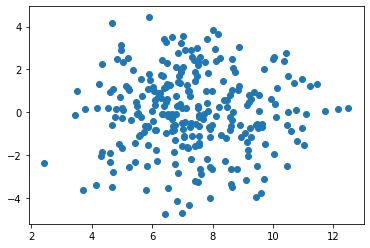

In [40]:
import matplotlib.pyplot as plt

plt.scatter(y_hat, residuals)

# Check that residuals are normally distributed

In [41]:
# do I run the qq plot on train, test, or a combination?
sorted_residuals = sorted(residuals)

In [42]:
len(residuals)

268

In [43]:
from scipy import stats

probs = [x/(len(residuals)+1) for x in range(1, len(residuals))]
z_scores = [stats.norm.ppf(prob) for prob in probs]



(-5.6961830419838275, 4)

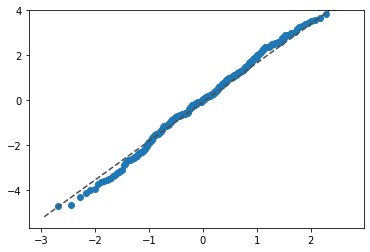

In [44]:
fig, ax = plt.subplots()
ax.scatter(z_scores, sorted(residuals)[0:-1])
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_ylim(top = 4)

In [45]:
from statsmodels.graphics.gofplots import qqplot

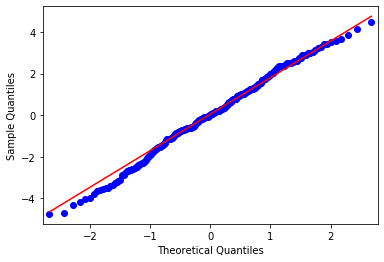

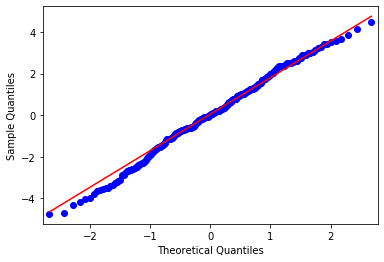

In [46]:
qqplot(residuals, line='q')

# Check that there is no covariance

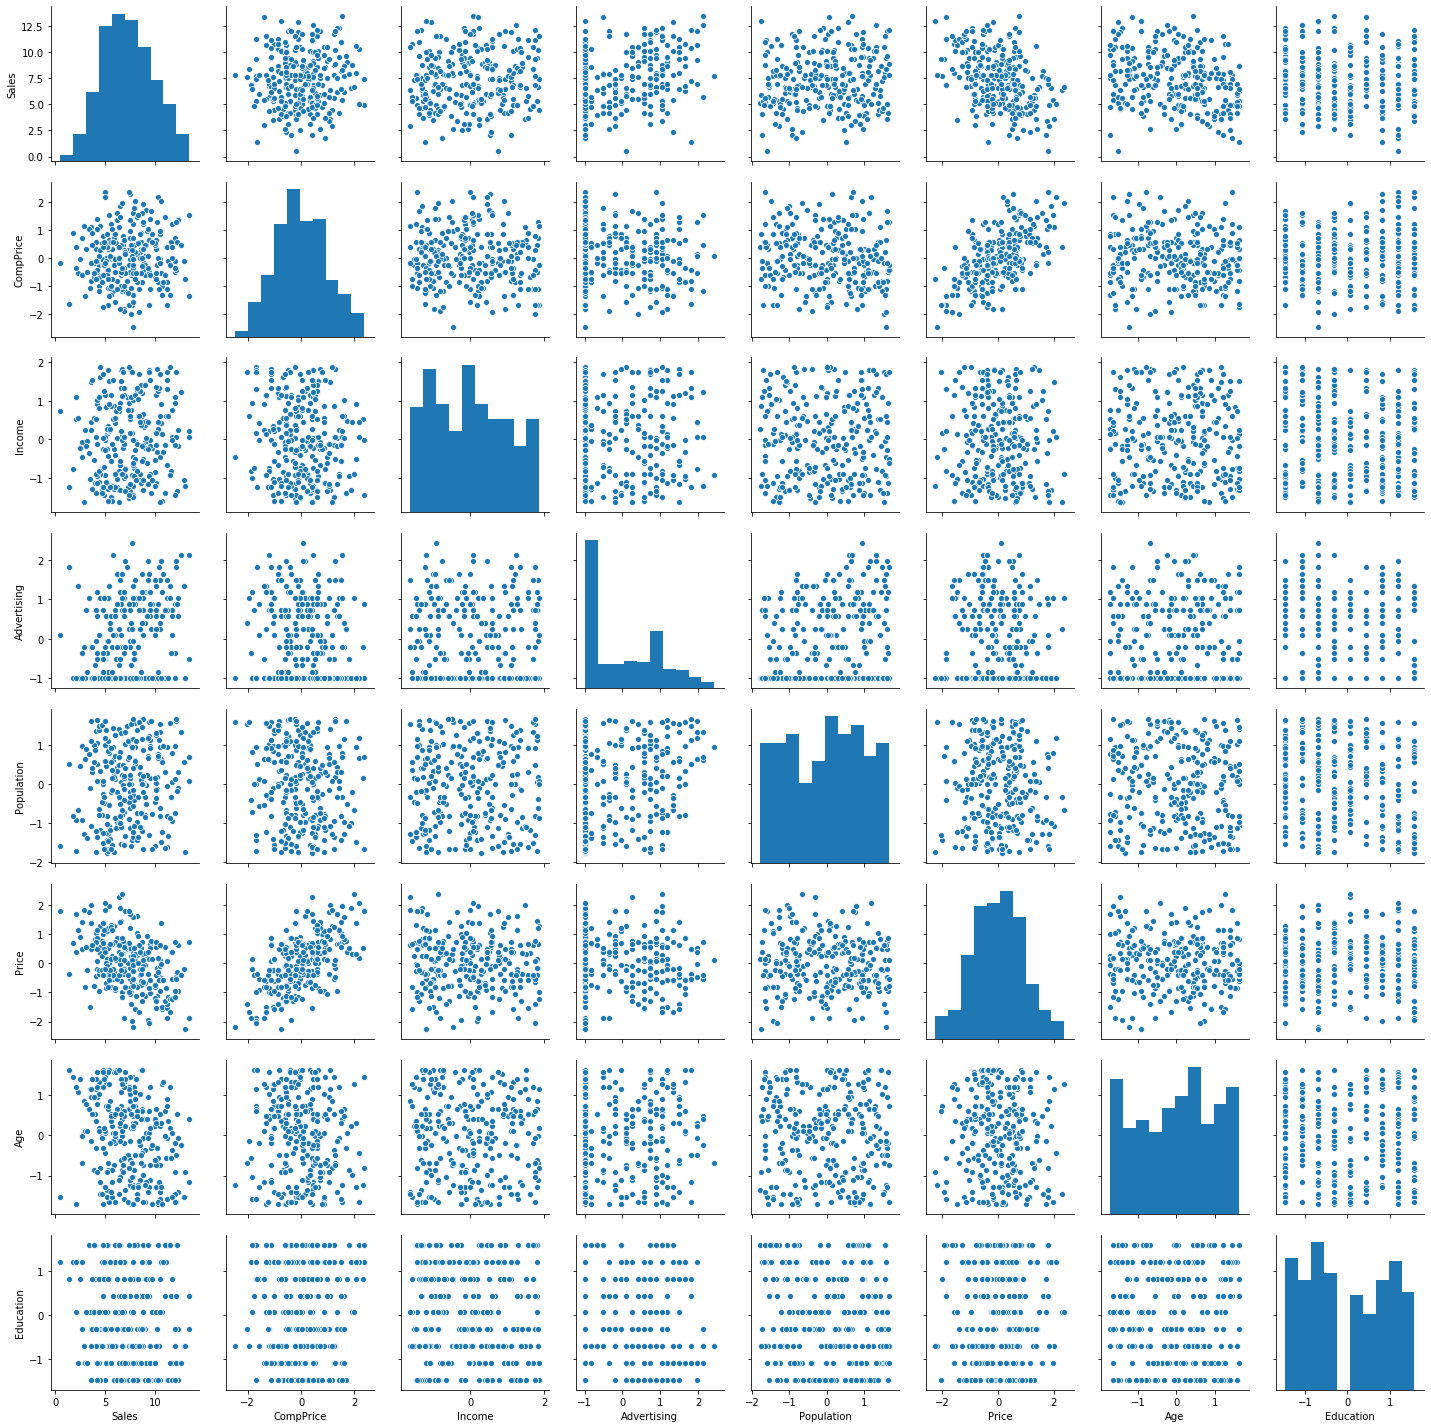

In [47]:
sns.pairplot(train_data)

In [48]:
# Covariance Matrix
# When we remove features with high covariance (between .7 and .8), 
# we protect against overfitting 

train_data.corr()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
Sales,1.000000,0.059597,0.087939,0.285493,0.109067,-0.405323,-0.281794,-0.078097
CompPrice,0.059597,1.000000,-0.090494,-0.086914,-0.123081,0.589298,-0.079017,0.066440
Income,0.087939,-0.090494,1.000000,0.045978,-0.023540,-0.056668,-0.032376,-0.132315
Advertising,0.285493,-0.086914,0.045978,1.000000,0.269623,-0.011863,0.005362,-0.098434
Population,0.109067,-0.123081,-0.023540,0.269623,1.000000,-0.073451,-0.062203,-0.145957
Price,-0.405323,0.589298,-0.056668,-0.011863,-0.073451,1.000000,-0.056181,0.031585
Age,-0.281794,-0.079017,-0.032376,0.005362,-0.062203,-0.056181,1.000000,-0.000671
Education,-0.078097,0.066440,-0.132315,-0.098434,-0.145957,0.031585,-0.000671,1.000000


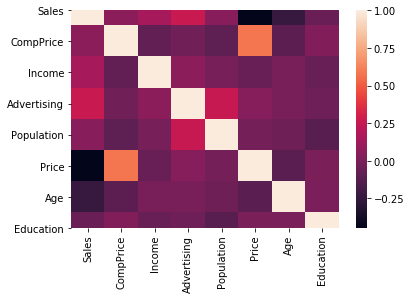

In [49]:
sns.heatmap(carseats.corr())

In [50]:
# looks like Price and CompPrice are highly correlated, so we need to drop one.

In [51]:
X_train.drop('CompPrice', axis=1, inplace=True )

In [76]:
X_train.corr()

,Income,Advertising,Population,Price,Age,Education
Income,1.000000,0.046546,-0.022125,-0.008397,-0.047805,-0.115540
Advertising,0.046546,1.000000,0.260959,-0.029130,-0.000911,-0.111959
Population,-0.022125,0.260959,1.000000,-0.022478,-0.044927,-0.114242
Price,-0.008397,-0.029130,-0.022478,1.000000,-0.095263,0.001449
Age,-0.047805,-0.000911,-0.044927,-0.095263,1.000000,0.007907
Education,-0.115540,-0.111959,-0.114242,0.001449,0.007907,1.000000


In [54]:
# Try again
feature_formula = " + ".join(X_train.columns)
sm_formula = 'Sales ~ ' + feature_formula

In [55]:
sm_formula

'Sales ~ Income + Advertising + Population + Price + Age + Education'

In [56]:
train_data = pd.merge(y_train, X_train, left_index=True, right_index=True)
results = smf.ols(sm_formula, data=train_data).fit()

In [57]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     22.42
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.86e-21
Time:                        07:40:03   Log-Likelihood:                -579.27
No. Observations:                 268   AIC:                             1173.
Df Residuals:                     261   BIC:                             1198.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3486      0.130     56.470      0.000       7.092       7.605
Income          0.0933      0.132      0.709      0.479      -0.166       0.352
Advertising     0.7596      0.141      5.397      0.000       0.482       1.037
Population     -0.0547      0.136     -0.402      0.688      -0.323       0.213
Price          -1.1839      0.143     -8.251      0.000      -1.467      -0.901
Age            -0.7955      0.131     -6.075      0.000      -1.053      -0.538
Education      -0.0917      0.132     -0.693      0.489      -0.352       0.169
==============================================================================
Omnibus:                        0.513   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.774   Jarque-Bera (JB):                0.636
Skew:                           0.021   Prob(JB):                        0.728
Kurtosis:                       2.765   Cond. No.                         1.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
X_train.drop(['Income', 'Population', 'Education'], axis=1, inplace=True )

In [59]:
# Try again
feature_formula = " + ".join(X_train.columns)
sm_formula = 'Sales ~ ' + feature_formula

In [60]:
sm_formula

'Sales ~ Advertising + Price + Age'

In [61]:
train_data = pd.merge(y_train, X_train, left_index=True, right_index=True)
results = smf.ols(sm_formula, data=train_data).fit()

In [62]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     44.72
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           2.12e-23
Time:                        07:46:58   Log-Likelihood:                -579.91
No. Observations:                 268   AIC:                             1168.
Df Residuals:                     264   BIC:                             1182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.3504      0.130     56.685      0.000       7.095       7.606
Advertising     0.7580      0.135      5.630      0.000       0.493       1.023
Price          -1.1885      0.142     -8.351      0.000      -1.469      -0.908
Age            -0.7953      0.130     -6.113      0.000      -1.051      -0.539
==============================================================================
Omnibus:                        0.551   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.759   Jarque-Bera (JB):                0.666
Skew:                           0.003   Prob(JB):                        0.717
Kurtosis:                       2.756   Cond. No.                         1.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Autocorrelation 

https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html

Statsmodel outputs a Durbin-Watson score between 0 and 4, with a value of 2 indicating no autocorrelation. Autocorrelated datasets will be the subject of time series at the end of the mod.


In [65]:
with open("scaler.p", 'rb') as read_file:
    scaler=pickle.load(read_file)

In [85]:
test_set = np.array([[124,67,3,4,5,4,5],[15,4,5,5,6,4,5]])
scaler.transform(test_set)


array([[-4.69880276e-02, -4.53348501e-03, -5.15045903e-01,
        -1.81253481e+00, -4.68474828e+00, -2.98804966e+00,
        -3.37421152e+00],
       [-6.97488466e+00, -2.22594114e+00, -2.05243856e-01,
        -1.80561438e+00, -4.64270702e+00, -2.98804966e+00,
        -3.37421152e+00]])

In [83]:
ss.mean_

array([124.73928571,  67.12857143,   6.325     , 265.91071429,
       116.43214286,  53.11785714,  13.84285714])